Autor:

Pablo González Martín

**Trabajo de Fin de Grado**  
- Autor: Pablo González Martín  
- Director: Carlos Javier Pérez González

Grado en Matemáticas  
Universidad de La Laguna  
2024/25

Este notebook forma parte del Trabajo de Fin de Grado titulado *“Fundamentos de las redes neuronales
convolucionales y su aplicación en la
detección de enfermedades oculares”*, cuyo objetivo es desarrollar un modelo de clasificación de enfermedades oculares a partir de imágenes médicas. En este notebook exploraremos las redes neuronales profundas sin convoluciones para realizar un clasificador binario entre imágenes que son radiografías oculares frente a imágenes que no lo son.

Este modelo se presenta como alternativa a otros más concocidos cómo:

- SVM
- Regresión lineal clásica
- Anomaly detection


## Imports

Librerías empleadas

In [3]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from collections import defaultdict
import keras
import sys
from keras import layers
from tensorflow.keras import layers, callbacks
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from keras_visualizer import visualizer
from IPython.display import Image
from tensorflow.keras.utils import plot_model   #descargar graphicz

In [12]:
from func1 import *   #en caso de incluir las funciones en un func.py en el mismo dir

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
sys.version

Num GPUs Available:  1
2.18.0


'3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]'

**IMPORTANTE** En caso de no tener GPU habilitada no ejecutar las celdas de las secciones de *Modelo* ya que pueden tardar mucho.

## Google Colab + Drive

**CASO USANDO DRIVE Y GOOGLE COLAB**. Incluir la carpeta con nombre dataset en MiUnidad en el Drive (en caso de tener los datos en local, declarar path como la ruta a la carpeta dataset)

In [8]:
path = os.path.join(os.getcwd(),'drive','MyDrive', 'dataset_clasificador_binario')

Montar Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset en local en esta carpeta

In [47]:
path=os.path.join(os.getcwd(),'dataset_clasificador_binario')

# Data estraction

Rutas

In [9]:
dir=os.getcwd()
path_dataset=path
carpetas = [
    os.path.join("dataset_clasificador_binario", "train", "radiography"),
    os.path.join("dataset_clasificador_binario", "train", "others"),
    os.path.join("dataset_clasificador_binario", "test", "radiography"),
    os.path.join("dataset_clasificador_binario", "test", "others")
]

Función para renombrar imágenes de forma {id}.formato En caso de tener el dataset en local.

In [ ]:
for carpeta in carpetas:
    renombrar_imagenes(carpeta)

Análisis del dataset de entrenamiento (train)

In [14]:
dataset_analysis(os.path.join(path_dataset,'train'))


Analyzing Subfolder: others

Subfolder Summary - others:
Total Images: 5212

Image Formats:
  - JPEG: 5212 images (100.00%)

Color Modes:
  - RGB: 5212 images (100.00%)

Bit Depths:
  - 24 bit: 5212 images (100.00%)

Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels

Analyzing Subfolder: radiography

Subfolder Summary - radiography:
Total Images: 5162

Image Formats:
  - PNG: 5162 images (100.00%)

Color Modes:
  - RGB: 5162 images (100.00%)

Bit Depths:
  - 24 bit: 5162 images (100.00%)

Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels


TOTAL DATASET OVERVIEW
Total Subfolders: 2
Total Images: 10374

Overall Image Formats:
  - JPEG: 5212 images (50.24%)
  - PNG: 5162 images (49.76%)

Overall Color Modes:
  - RGB: 10374 images (100.00%)

Overall Bit Depths:
  - 24 bit: 10374 images (100.00%)

Overall Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels


Análisis del dataset de testeo (test)

In [15]:
dataset_analysis(os.path.join(path_dataset,'test'))


Analyzing Subfolder: radiography

Subfolder Summary - radiography:
Total Images: 566

Image Formats:
  - PNG: 566 images (100.00%)

Color Modes:
  - RGB: 566 images (100.00%)

Bit Depths:
  - 24 bit: 566 images (100.00%)

Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels

Analyzing Subfolder: others

Subfolder Summary - others:
Total Images: 416

Image Formats:
  - JPEG: 416 images (100.00%)

Color Modes:
  - RGB: 416 images (100.00%)

Bit Depths:
  - 24 bit: 416 images (100.00%)

Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels


TOTAL DATASET OVERVIEW
Total Subfolders: 2
Total Images: 982

Overall Image Formats:
  - PNG: 566 images (57.64%)
  - JPEG: 416 images (42.36%)

Overall Color Modes:
  - RGB: 982 images (100.00%)

Overall Bit Depths:
  - 24 bit: 982 images (100.00%)

Overall Dimension Ranges:
  - Width:  224 - 224 pixels
  - Height: 224 - 224 pixels


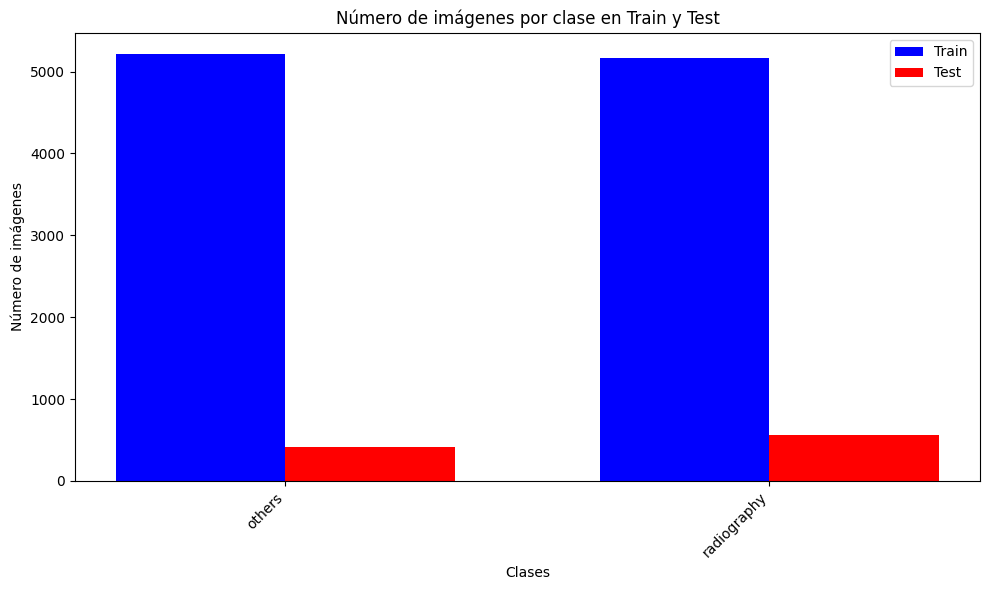

In [16]:
plot_image_counts(path_dataset)

**Creamos los objetos dataset**

Imágenes del conjunto de entrenamiento ( y su respectivo conjunto de validación)

Podemos definir el porcentaje de la carpeta con la que trabajamos

In [22]:
train_ds, val_ds = load_datasettrain_with_subset(
    directory=os.path.join(path_dataset,'train'),
    train_subset_percentage=0.8,  # Usar solo el x% de los datos de entrenamiento
    validation_split=0.2,
    batch_size=16,
    image_size=(224, 224)
)

Using 8300 files for training.
Using 2074 files for validation.
Total training batches: 519
Subset training batches: 415
Validation batches: 130


In [23]:
# Mostrar la distribución de clases para los datasets de entrenamiento y validación
print("Distribución de clases en el conjunto de entrenamiento:")
show_class_distribution(train_ds)

print("\nDistribución de clases en el conjunto de validación:")
show_class_distribution(val_ds)

Distribución de clases en el conjunto de entrenamiento:
Distribución de clases:
Clase 0 (others): 3365 (50.68%)
Clase 1 (radiography): 3275 (49.32%)

Distribución de clases en el conjunto de validación:
Distribución de clases:
Clase 0 (others): 1038 (50.05%)
Clase 1 (radiography): 1036 (49.95%)


Imágenes del conjunto de testeo

In [24]:
test_ds = keras.utils.image_dataset_from_directory(
    directory = os.path.join(path_dataset,'test'),    #test_data
    labels="inferred",  #automatic labels
    label_mode="binary",    #clasificador binario
    class_names=["others","radiography"],   #clases
    color_mode="rgb",      #fotos a color
    batch_size=16,
    image_size=(224, 224),
    seed=None,
    shuffle=True,   #importante
    subset=None,
    interpolation="bilinear",
    verbose=True,
)

Found 982 files belonging to 2 classes.


In [25]:
print("\nDistribución de clases en el conjunto de validación:")
show_class_distribution(test_ds)


Distribución de clases en el conjunto de validación:
Distribución de clases:
Clase 0 (others): 416 (42.36%)
Clase 1 (radiography): 566 (57.64%)


Mostrar imágenes dentro del dataset

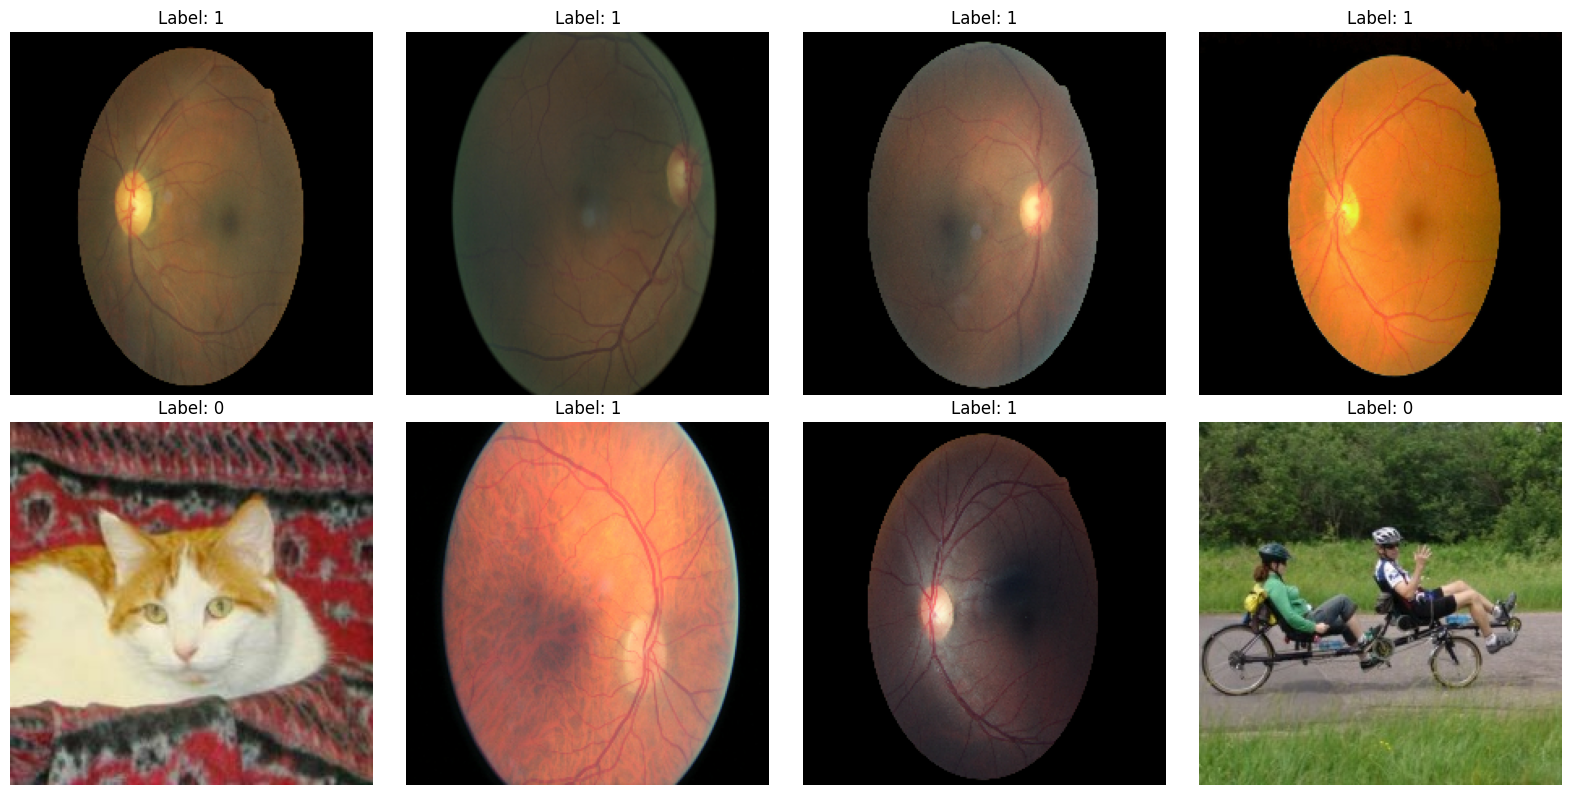

In [26]:
show_random_images(train_ds, num_images=8, images_per_row=4)

# Modelo

*Mejora de rendimiento*

El método prefetch de TensorFlow se utiliza para optimizar el procesamiento de datos en el pipeline de entrenamiento, asegurando que el modelo esté alimentado con datos de manera eficiente y que las operaciones de lectura de datos y entrenamiento no se bloqueen entre sí.

En términos más simples:

prefetch permite que el procesamiento de datos se realice en paralelo con el entrenamiento. Mientras el modelo está entrenando con un lote de datos, el siguiente lote de datos se prepara en segundo plano. Esto ayuda a mejorar la velocidad de entrenamiento, ya que reduce el tiempo de espera al cambiar entre lotes de datos

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Generamos el modelo y guardamos la información de su entrenamiento  (modelo con capas densas y modelo con capas convolucionales)

## Modelo denso

In [28]:
dense_model=make_model(input_shape=(224, 224, 3), num_layers=2, num_neurons=4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       602,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4)              │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 602,173 (2.30 MB)

 Trainable params: 602,157 (2.30 MB)

 Non-trainable params: 16 (64.00 B)

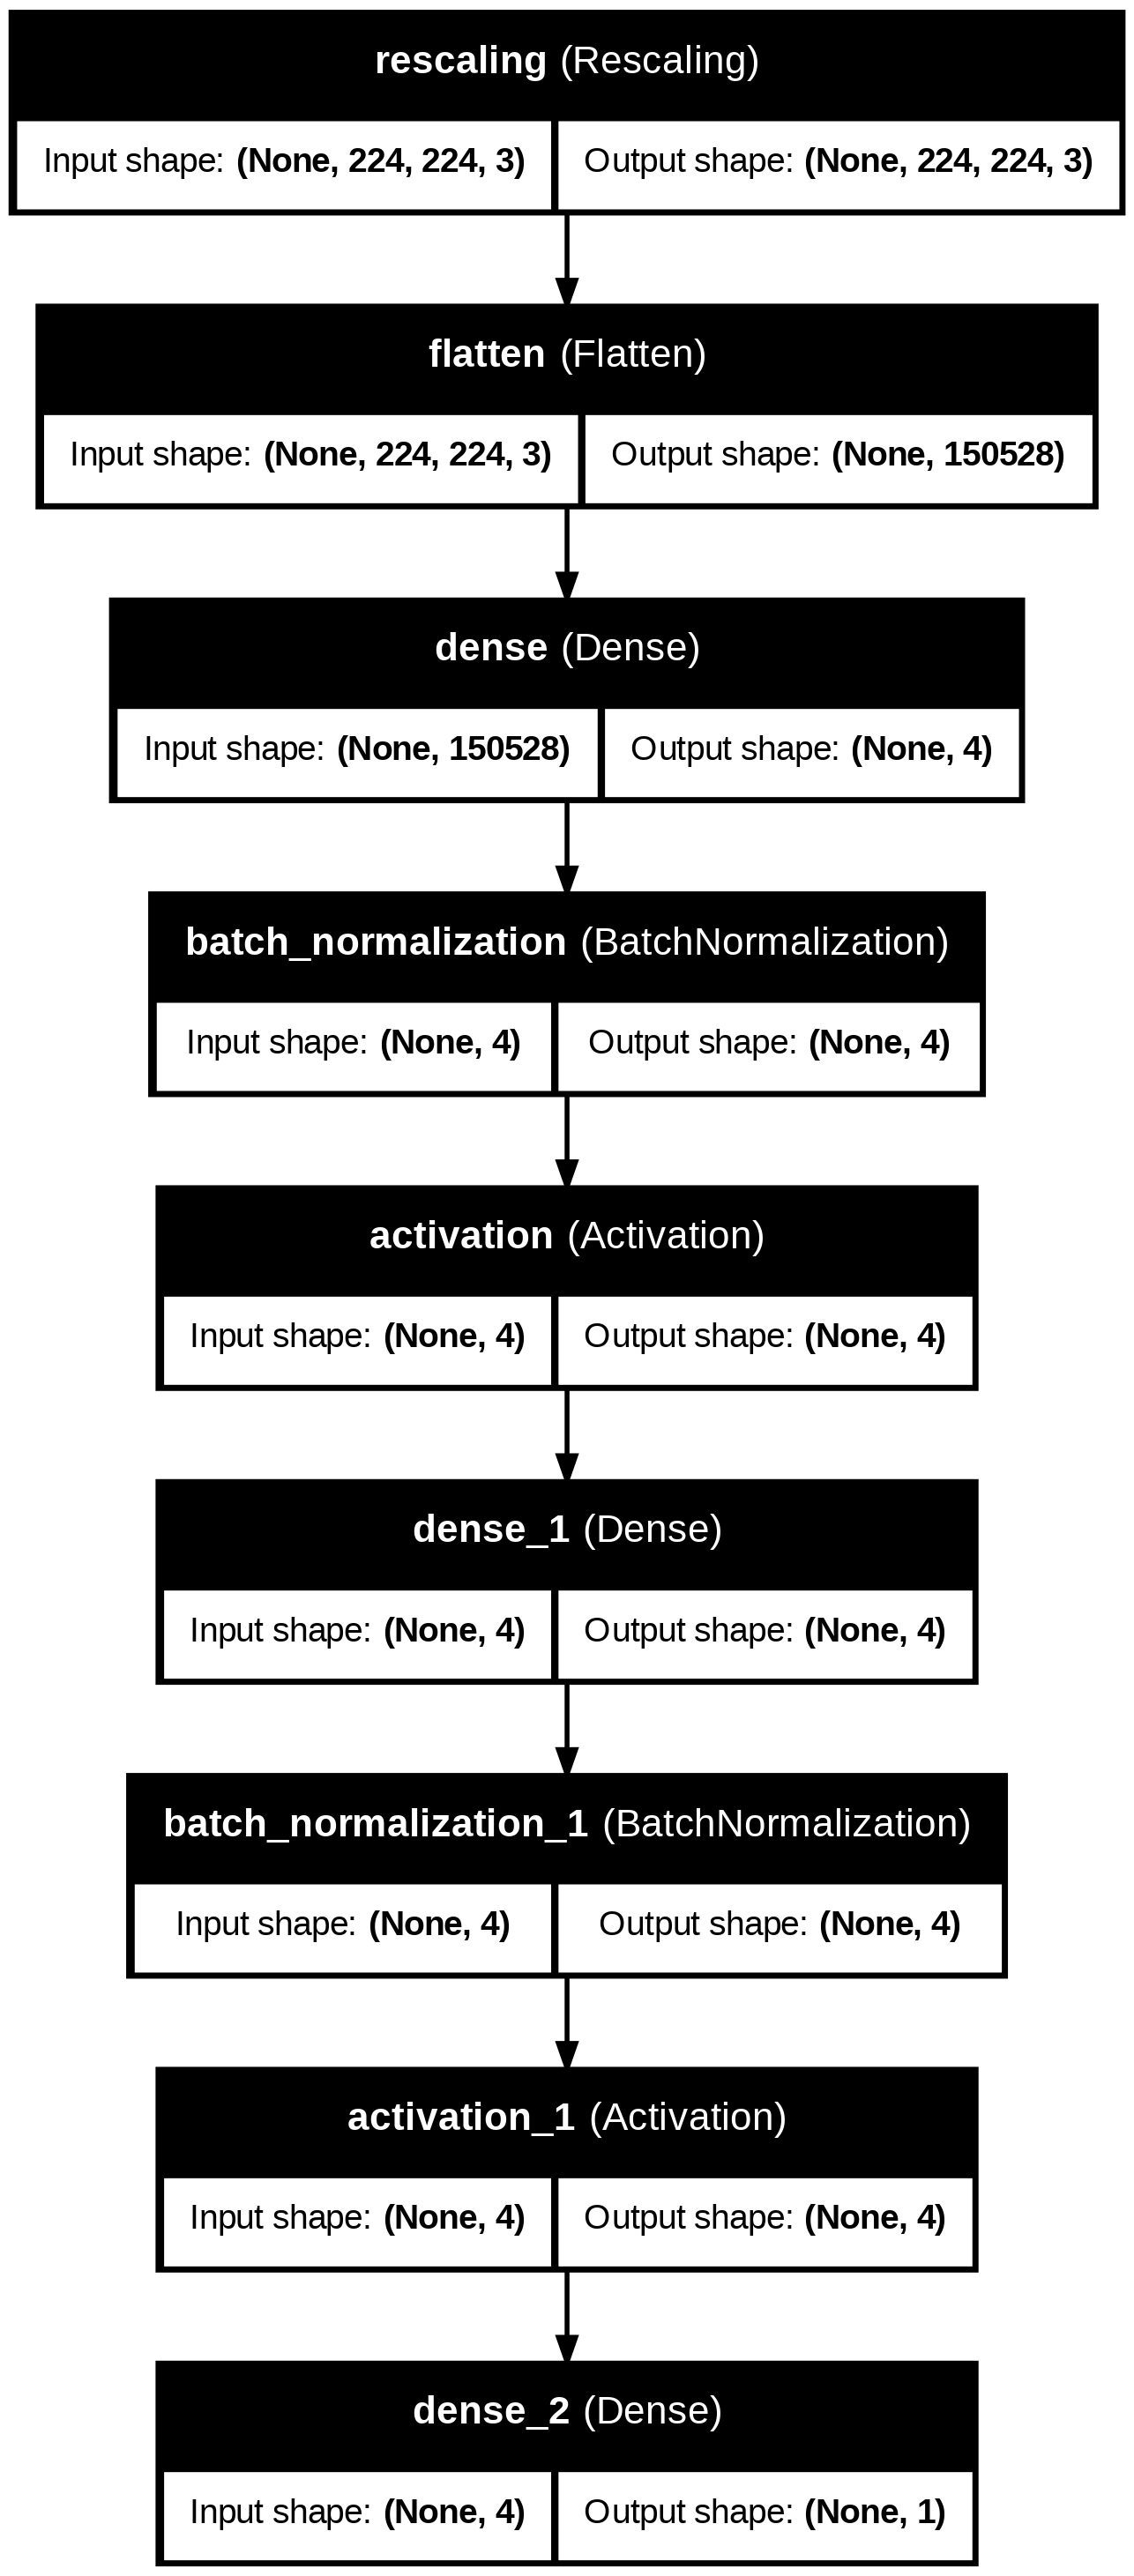

In [29]:
plot_model(dense_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualizer(model=dense_model, file_name="model.png")

Entrenamiento del modelo

In [30]:
class CompactTrainMetrics(keras.callbacks.Callback):
    def __init__(self, train_data):
        super().__init__()
        self.train_data = train_data
        self.train_metrics = {
            'loss': [],
            'accuracy': []
        }
        self.val_metrics = {
            'loss': [],
            'accuracy': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Reset metrics before evaluation
        self.model.reset_metrics()

        # Prepare lists to collect batch-level predictions and true labels
        all_predictions = []
        all_true_labels = []
        total_loss = 0.0
        num_batches = 0

        # Iterate through the entire training dataset
        for batch_x, batch_y in self.train_data:
            # Compute predictions
            batch_predictions = self.model(batch_x, training=False)

            # Determine loss function based on label and prediction shapes
            if len(batch_y.shape) == 1 or batch_y.shape[1] == 1:
                # Binary classification or single-column labels
                batch_loss = tf.keras.losses.binary_crossentropy(
                    batch_y, batch_predictions, from_logits=False
                )
                # Convert to multi-class style for accuracy calculation
                predicted_classes = tf.round(batch_predictions)
                true_classes = batch_y
            else:
                # Multi-class classification
                batch_loss = tf.keras.losses.categorical_crossentropy(
                    batch_y, batch_predictions, from_logits=False
                )
                predicted_classes = tf.argmax(batch_predictions, axis=1)
                true_classes = tf.argmax(batch_y, axis=1)

            # Accumulate results
            total_loss += tf.reduce_mean(batch_loss).numpy()
            num_batches += 1

            # Collect predictions and true labels
            all_predictions.append(predicted_classes)
            all_true_labels.append(true_classes)

        # Concatenate predictions and true labels
        all_predictions = tf.concat(all_predictions, axis=0)
        all_true_labels = tf.concat(all_true_labels, axis=0)

        # Compute accuracy
        train_accuracy = tf.reduce_mean(tf.cast(tf.equal(all_predictions, all_true_labels), tf.float32)).numpy()

        # Compute average loss
        average_loss = total_loss / num_batches

        # Store training metrics
        self.train_metrics['loss'].append(average_loss)
        self.train_metrics['accuracy'].append(train_accuracy)

        # Store validation metrics
        self.val_metrics['loss'].append(logs.get('val_loss', float('nan')))
        self.val_metrics['accuracy'].append(logs.get('val_accuracy', float('nan')))

        # Print compact summary
        print(f"\nEpoch {epoch+1}: Train Loss = {average_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, "
              f"Val Loss = {self.val_metrics['loss'][-1]:.4f}, Val Accuracy = {self.val_metrics['accuracy'][-1]:.4f}")


final_metrics_callback = CompactTrainMetrics(train_ds)


callbacks = [
    keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2),
    final_metrics_callback
]


history1 = dense_model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks=callbacks,
    class_weight={0: 1, 1: 1}
)

Epoch 1/10
414/415 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8819 - loss: 0.4204
Epoch 1: Train Loss = 0.1618, Train Accuracy = 0.9801, Val Loss = 0.1765, Val Accuracy = 0.9711
415/415 ━━━━━━━━━━━━━━━━━━━━ 60s 135ms/step - accuracy: 0.8821 - loss: 0.4200 - val_accuracy: 0.9711 - val_loss: 0.1765 - learning_rate: 0.0010
Epoch 2/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9632 - loss: 0.1758
Epoch 2: Train Loss = 0.0539, Train Accuracy = 0.9968, Val Loss = 0.0620, Val Accuracy = 0.9937
415/415 ━━━━━━━━━━━━━━━━━━━━ 113s 216ms/step - accuracy: 0.9632 - loss: 0.1757 - val_accuracy: 0.9937 - val_loss: 0.0620 - learning_rate: 0.0010
Epoch 3/10
415/415 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9815 - loss: 0.0846
Epoch 3: Train Loss = 0.0344, Train Accuracy = 0.9976, Val Loss = 0.0421, Val Accuracy = 0.9947
415/415 ━━━━━━━━━━━━━━━━━━━━ 130s 186ms/step - accuracy: 0.9815 - loss: 0.0845 - val_accuracy: 0.9947 - val_loss: 0.0421 - learning_rate: 0.0010
Epoch 4/10
415/41

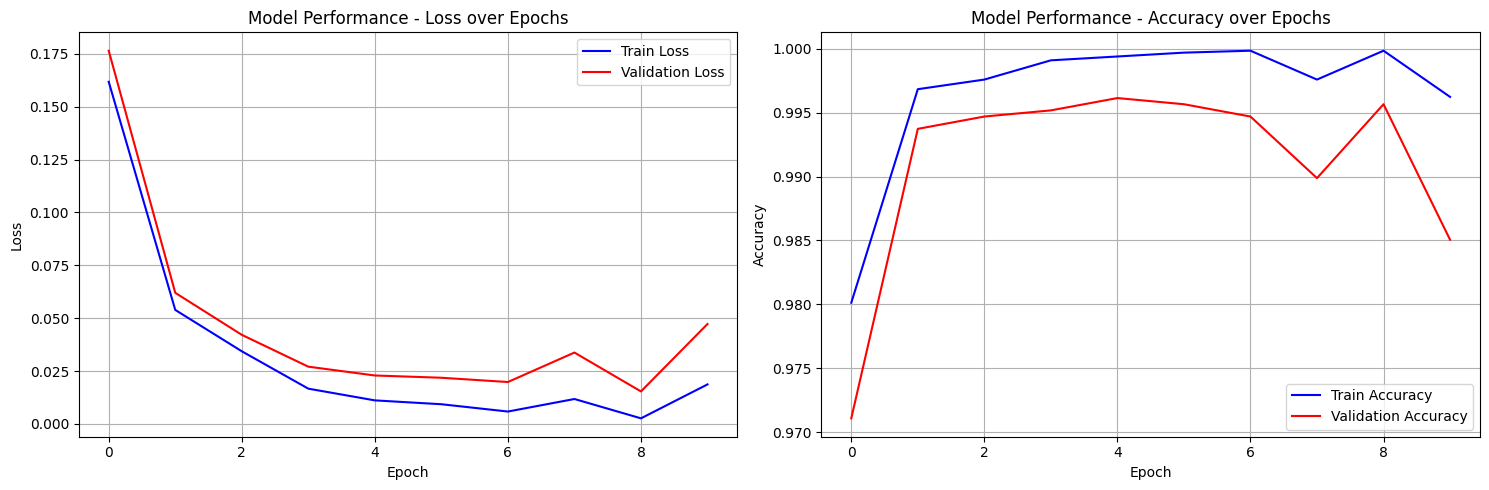

In [37]:
plot_training_metrics(
    final_metrics_callback.train_metrics,
    final_metrics_callback.val_metrics,
    title_prefix='Model Performance - '
)

In [38]:
dense_model.save('modelo_denso_clasificador_binario.keras')

# Visualización y conclusiones

Modelo entrenado en caso de no estar usando GPU

In [39]:
nombre='modelo_denso_clasificador_binario.keras'
dense_model.save(nombre)

Usando estadíticas de Keras

Reporte de clasificación para dataset:
              precision    recall  f1-score     support
others         1.000000  0.980769  0.990291  416.000000
radiography    0.986063  1.000000  0.992982  566.000000
accuracy       0.991853  0.991853  0.991853    0.991853
macro avg      0.993031  0.990385  0.991637  982.000000
weighted avg   0.991967  0.991853  0.991842  982.000000


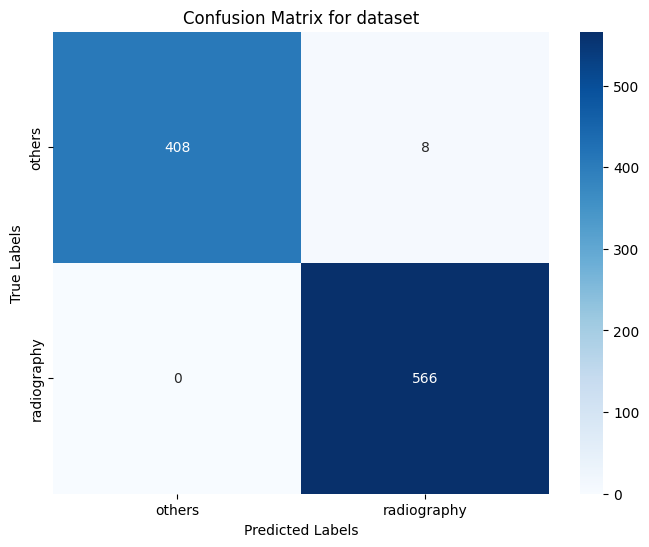

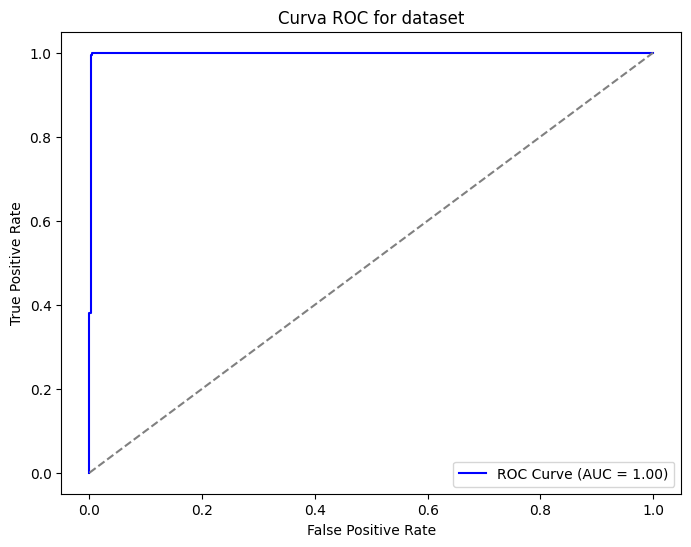

{'accuracy': 0.9918533604887984,
 'precision': 0.9860627177700348,
 'recall': 1.0,
 'f1': 0.9929824561403509,
 'auc': np.float64(0.9984880402283229)}

In [32]:
evaluate_model(dense_model, test_ds)

**Índice de Youden (J)**

El **Índice de Youden** es una medida estadística que evalúa la efectividad de un clasificador binario, combinando sensibilidad y especificidad en un solo valor:

$$J = Sensibilidad + Especificidad - 1$$

Este índice:
- Varía entre 0 (clasificador aleatorio) y 1 (clasificador perfecto)
- Representa la altura máxima entre la curva ROC y la diagonal
- Ayuda a determinar el punto de corte óptimo para la clasificación
- Es especialmente útil en conjuntos de datos desbalanceados

En el contexto de la matriz de confusión:

$$J = \frac{TP}{TP+FN} + \frac{TN}{TN+FP} - 1$$

donde TP = verdaderos positivos, TN = verdaderos negativos, FP = falsos positivos, FN = falsos negativos.

In [33]:
J = youden_index(dense_model, train_ds)
print(f"Índice de Youden: {J:.4f}")

Índice de Youden: 0.9997


Visualizar Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


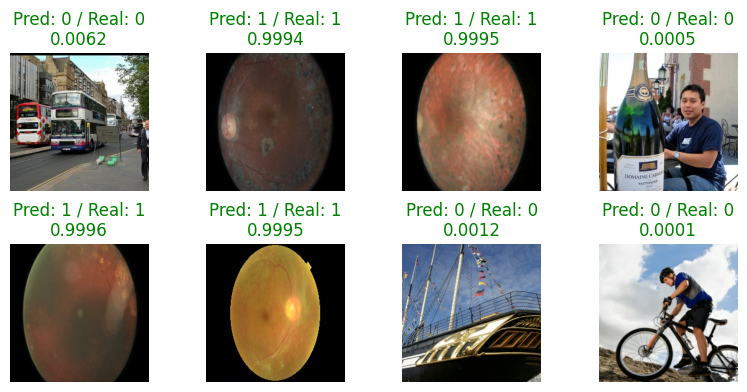

In [34]:
# Mostrar las predicciones
visualize_predictions(dense_model, test_ds, num_images=8, images_per_row=4)

Visualizando las predicciones incorrectas

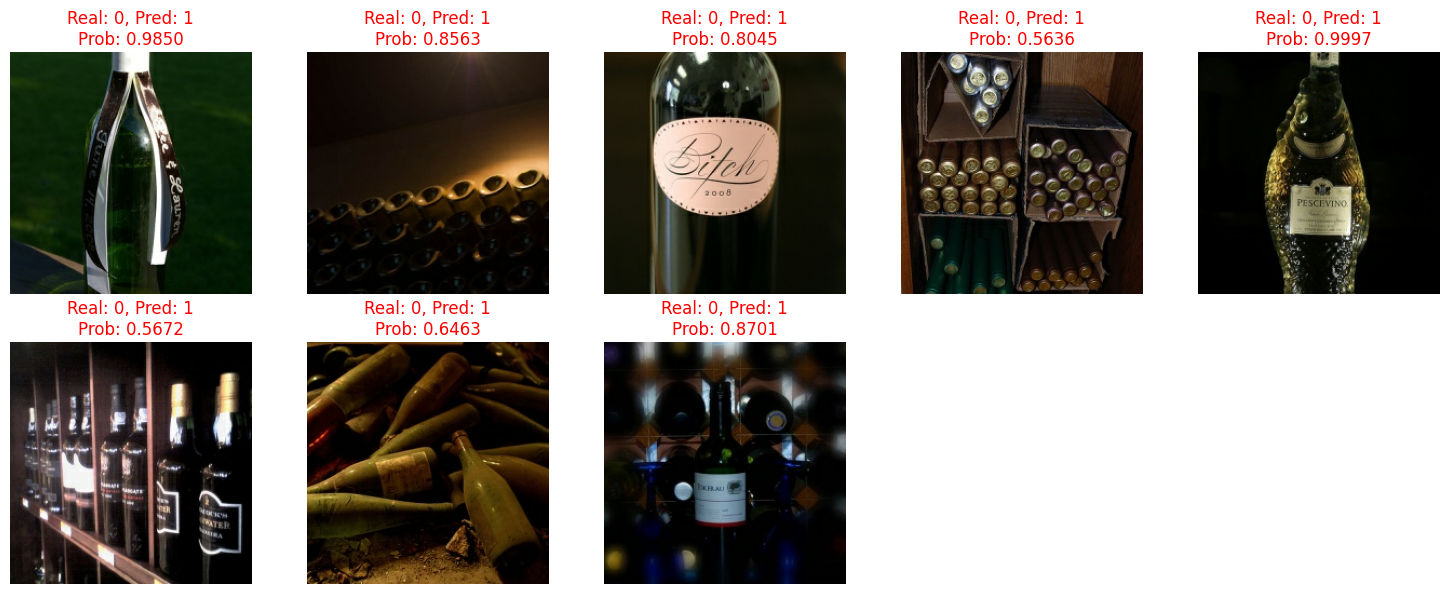

In [35]:
incorrect_images, incorrect_labels, incorrect_predictions, incorrect_probabilities=visualize_incorrect_predictions(dense_model, test_ds, num_images=30, images_per_row=5,corte=0.5)

# Imágenes confusas

In [48]:
extra_ds = keras.utils.image_dataset_from_directory(
    directory = os.path.join(path_dataset,'extra'),    #extra_data
    labels="inferred",  #automatic labels
    label_mode="binary",    #clasificador binario
    class_names=["others","radiography"],   #clases
    color_mode="rgb",      #fotos a color
    batch_size=16,
    image_size=(224, 224),
    seed=None,
    shuffle=True,   #importante
    subset=None,
    interpolation="bilinear",
    verbose=True,
)

Found 12 files belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step


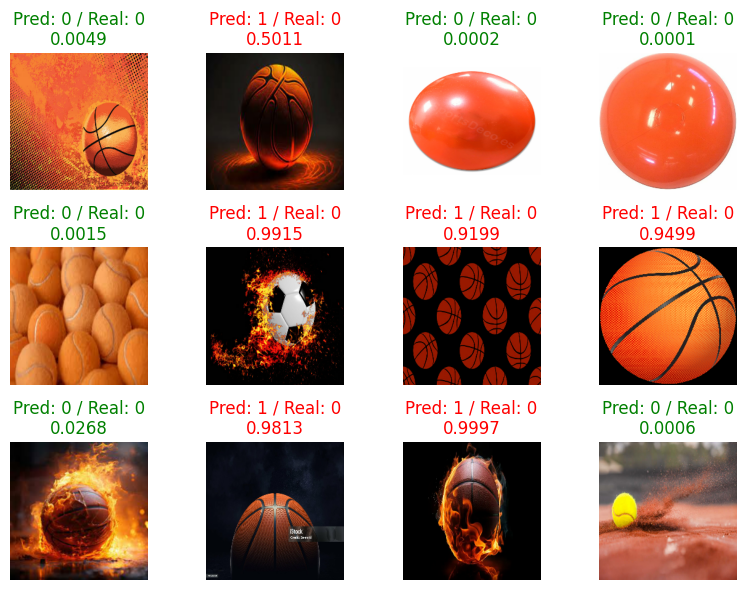

In [49]:
visualize_predictions(dense_model, extra_ds, num_images=20, images_per_row=4, corte=0.5)

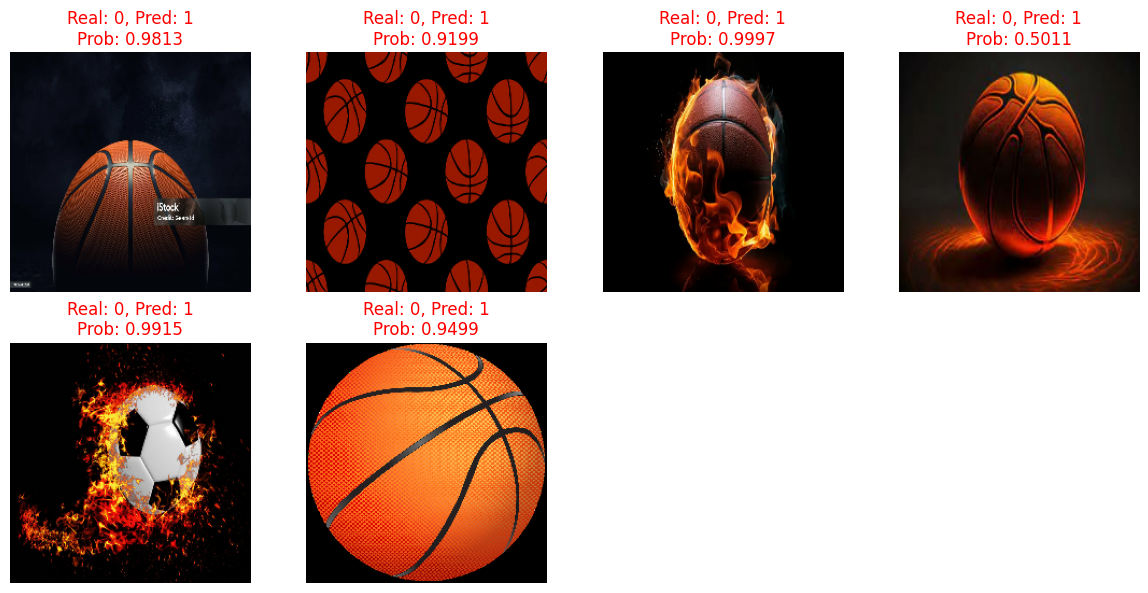

In [50]:
incorrect_images, incorrect_labels, incorrect_predictions, incorrect_probabilities=visualize_incorrect_predictions(dense_model, extra_ds, num_images=10, images_per_row=4,corte=0.5)